# Quasilinear theory of Alfvenic Turbulence

In [1]:
"""Preliminary Setup"""

import numpy as np 
import numpy.random as rnd
import matplotlib.pyplot as plt
import h5py
import os
from time import time
%matplotlib inline
from code.plot_utils import plot_pretty
plot_pretty()

import pyfits
from astropy.io import fits

In [2]:
"""Basic definitions"""
# constants (cgs units)
mp = 1.673e-24       # ion (proton) mass
mp2e = 1836.15267389 # proton to electron mass ratio
qe = 4.803e-10       # elementary charge
c = 2.998e10         # speed of light
kB = 1.3807e-16      # Boltzmann constant

# plasma properties
n0 = 1.e10              # plasma number density
T = 1.e6                # ion temperature
vth = np.sqrt(kB*T/mp)  # ion thermal speed

# box
lz = 10.**9       # x dimension
lx, ly = 1., 1.   # y and z dimensions (small compared to lx)

# excited modes
B0 = 1.e4                      # ambient magnetic field, in +z direction
vA = B0/np.sqrt(4*np.pi*n0*mp) # alfven speed
Wtot = 1.e-3                   # total wave energy density
q = 2.                         # power-spectrum index: W(k) = k^-q

# frequencies
omegac = qe*B0/(mp*c)                 # ion gyrofrequency
omegap = np.sqrt(4*np.pi*n0*qe**2/mp) # ion plasma frequency

In [3]:
"""Adopted code units"""
# r0 (length): skin depth, vA/omegac = c/omegap
r0 = vA/omegac

# m0 (mass): ion mass, mi
m0 = mp

# t0 (time): inverse gyrofrequency, 1/Omegac
t0 = 1./omegac

# v0 (velocity): alfven speed, vA
v0 = vA

# B0 (magnetic field): B0

# E0 (electric field): vA*B0/c
E0 = vA*B0/c

## Waves

Starting from
$$W_k \equiv \frac{|B_k|^2}{8 \pi} = C_k k^{-q},$$
where
$$C_k = \frac{(1-q) W_{\rm tot}}{k_{\min}^{1-q}} \left[ \left( \frac{k_{\max}}{k_{\min}} \right)^{1-q} - 1 \right]^{-1}$$
and $W_{\rm tot}$ is the total wave energy, we can write
$$|B_\mathbf{k}| = 2\sqrt{2\pi C_k} k^{-q/2}.$$

Also, since $|B_\mathbf{k}| = |\mathbf{k} \times \mathbf{A}_\mathbf{k}| = |kA_\mathbf{k} \sin (\pi/2 - \theta_\mathbf{k})|$, we also get
$$|A_\mathbf{k}| = \frac{2\sqrt{2\pi C_k}}{\cos \theta_\mathbf{k}} k^{-1-q/2} \; .$$

$\theta_\mathbf{k}$ is distributed according to a normal distribution around $\pi/4$. 

In units of $W_m = B_0^2/8\pi$, the energy of the waves is
$$ \tilde{W}_{\rm tot} = |\delta \tilde{B}|^2 \equiv \left( \frac{|\delta B|}{B_0} \right)^2 \equiv R^2 \; , $$
which is th parameter that determines how strong the waves are. We will formulate our code in terms of that.

Then, for instance, in code units where the energy unit is $E_0 = B_0^2/8\pi$, 
$$ \tilde{C}_k = \frac{(1-q)R^2}{\tilde{k}_{\max}^{1-q} - \tilde{k}_{\min}^{1-q}} \; $$
where $C_{k,0} = (B_0^2/8 \pi)(v_A/\Omega)^{1-q}$ are its units. Also, then, the units of $W_\mathbf{k}$ are $W_{k,0} = (B_0^2/8 \pi)(v_A/\Omega)$.

Also, note that, for the electric field, we write
$$ \mathbf{E} = - \frac{1}{c} \frac{\partial \mathbf{A}}{\partial t} = - \frac{1}{c} \frac{\partial}{\partial t} \sum \limits_{k=k_{\min}}^{k_{\max}} \mathbf{A}_\mathbf{k} \cos \left( \omega_\mathbf{k} t - \mathbf{k} \cdot \mathbf{x} + \phi_\mathbf{k} \right) = \sum \limits_{k=k_{\min}}^{k_{\max}} \mathbf{A}_\mathbf{k} \frac{\omega_\mathbf{k}}{c} \sin \left( \omega_\mathbf{k} t - \mathbf{k} \cdot \mathbf{x} + \phi_\mathbf{k} \right) \; ,$$
and $E_0 = v_A B_0/c$ are the units of the electric field and $A_0 =v_A B_0/\Omega$ are the unit of the vector potential. Finally, the dimrnsionless Electric field expression is
$$ \tilde{\mathbf{E}} = \sum \limits_{\tilde{k}=\tilde{k}_{\min}}^{\tilde{k}_{\max}} \tilde{\mathbf{A}}_\mathbf{k} \tilde{\omega}_\mathbf{k} \sin \left( \omega_\mathbf{k} t - \mathbf{k} \cdot \mathbf{x} + \phi_\mathbf{k} \right) \; ,$$

In [4]:
"""The excited Alfven spectrum"""
# wavevector
# note: k forms an angle theta_k with the +z direction
# note: k_min=1/v_max -> see (Miller, Geussoum, and Ramaty (1990))
#       v_max~10^-3 => k_min~10^3
Nk = 2**8                 # number of excited modes
kmin, kmax = 1.e-1, 1.e5  # minimum and maximum k
lkmin, lkmax = np.log10(kmin), np.log10(kmax)
k_array = 10**np.linspace(lkmin, lkmax, Nk)

# array of theta_k values
# note: they are chosen in a random manner
#       for moderate angles around pi/4
theta_k = rnd.normal(np.pi/4., np.pi/16., Nk)

# dispesion relation
omegak = k_array * np.cos(theta_k)

# random phase array
phi_k = rnd.uniform(0., 2*np.pi, Nk)

# strength of magnetic field perturbations
R = 1.e-2

# normalization factor of Wk
Ck = (1.-q) * R**2 / ( k_array[-1]**(1.-q) - k_array[0]**(1.-q) )

# amplitude of deltaB_k and deltaE_k
amplB_k = np.sqrt(Ck) * k_array**(-q/2.)
amplE_k = np.sqrt(Ck) * k_array**(-1.-q/2.) * omegak

## Particle integration

The equations of motion for the ions are
$$\frac{d(\gamma \boldsymbol{\beta})}{dt} = \frac{e}{mc}\left( \mathbf{E} + \boldsymbol{\beta} \times \mathbf{B} \right) \; ,$$
where
$$ \gamma = \frac{1}{\sqrt{1 - \beta^2}} \; . $$

The dimensionalized ones are expressed as
$$ \frac{d\mathbf{\tilde{v}}}{d \tilde{t}} = - \frac{1}{\gamma} \frac{d \gamma}{d\tilde{t}} \mathbf{\tilde{v}} + \delta \tilde{\mathbf{E}} + \tilde{\mathbf{v}} \times \left( \hat{\mathbf{e}}_z + \delta \tilde{B} \; \hat{\mathbf{e}}_y \right) $$
with
$$\gamma = \frac{1}{\sqrt{1 + (v_A/c)^2 \tilde{v}^2}} \; .$$
We also have that 
$$\frac{d\gamma}{dt} = \frac{\gamma^3}{c^2} \mathbf{v} \cdot \frac{d\mathbf{v}}{dt} \; \; \Rightarrow \; \; \frac{d\gamma}{d\tilde{t}} = \left[ \left( \frac{c}{\gamma v_A} \right)^2 + \tilde{v}^2 \right]^{-1} \gamma \delta \tilde{E} \; \tilde{v}_x \; .$$

We will drop the tilde symbols for convenience, since all equations are non-dimensional from now on. Then, the equations of motion become
$$ \frac{dv_x}{dt} = \left( \frac{1}{\gamma} - f v_x^2 \right) \delta E + \frac{1}{\gamma} v_y - \frac{\delta B}{\gamma} v_z $$
$$ \frac{dv_y}{dt} = - \frac{1}{\gamma} v_x - f \delta E v_x v_y $$
$$ \frac{dv_x}{dt} =   \frac{\delta B}{\gamma} v_x - f \delta E v_x v_z $$
where 
$$ f \equiv \left[ \left( \frac{c}{\gamma v_A} \right)^2 + \tilde{v}^2 \right]^{-1} \; . $$

### Stability analysis (in progress...)

The particle with the maximum velocity, say $v_{\max}$, travels $\Delta x = v_{\max} \Delta t$ in a time step. Lets say that this distance must be a fraction $f$ of a full gyromotion, $\ell_g = 2 \pi r_L = 2 \pi v_{\perp , \max} / \Omega$, i.e.
$$ \Delta x \leq f \ell_g \; \; \Rightarrow \; \; \Delta \tilde{t} \leq 2 \pi f \frac{v_{\perp , \max}}{v_{\max}} $$

In [5]:
def gamma(v):
    """
    Lorentz factor
    
    input
    -----
    v: numpy array or float
        dimensionless velocity
    """
    v2 = np.sum(v*v,1)
    return 1. / np.sqrt(1. - (vA/c)**2 * v2)

def Ekin(v):
    """
    Kinetic energy of particles
    (in units of mp*vA^2)
    
    input
    -----
    v: numpy array
        normalized velocities
    """
    return (gamma(v)-1.) * (c/vA)**2.

def compute_deltaB_deltaE(x, t):
    """
    Computes delta_B and delta_E at the same time at (x,t)
    
    input
    -----
    k: numpy array
        normalized wavenumber
    t: float
        time moments
    """
    Nx = len(x[:,0]) # number of particles = number of positions to calculate the fields at
    innx = np.indices( (Nx,Nx) )
    
    # dot product of k and x: k.x = k_x*x + k_z*z = k*x*sin(theta_k) + k*z*cos(theta_k)
    # ... compute (Np x 1) vectors of x and y, so we can multiply by k each position
    xvec = x[:,0][innx][0,:,0][:,np.newaxis]
    yvec = x[:,1][innx][0,:,0][:,np.newaxis]
    # ... and now compute the dot product
    k_dot_x = xvec*k_array*np.sin(theta_k) + yvec*k_array*np.cos(theta_k)
        
    # phase of deltaB_k
    phaseB_k = np.cos(omegak*t - k_dot_x + phi_k)
    # phase of deltaE_k
    phaseE_k = np.sin(omegak*t - k_dot_x + phi_k)
        
    # deltaB at position i, at time t
    deltaB = np.sum(amplB_k*phaseB_k,1)
    # deltaE at position i, at time t
    deltaE = np.sum(amplE_k*phaseE_k,1)

    return deltaB, deltaE

def compute_acc(x, v, t):
    """Acceleration at position x and time t"""
    # magnetic and electric fields at (x,t)
    deltaB, deltaE = compute_deltaB_deltaE(x, t)
    
    v2 = np.sum(v*v,1); gL = gamma(v)
    fact = 1. / ( (c/(gL*vA))**2 + v2 )
    
    # rhs of equations of motion
    dvdt_x = (1./gL - fact * v[:,0]**2) * deltaE + v[:,1]/gL - deltaB * v[:,2] / gL
    dvdt_y = - v[:,0] / gL - fact * deltaE * v[:,0] * v[:,1]
    dvdt_z = deltaB * v[:,0] / gL - fact * deltaE * v[:,0] * v[:,2]
    
    return np.array(zip(dvdt_x, dvdt_y, dvdt_z))

def DKD_step(x, v, t, dt):
    """
    Symplectic stepping scheme (similar to leap-frog method)
    1) First, the position of a particle is advanced by half time step (1st-order Euler scheme)
    2) Then, the velociy is updated by full time step using the positions at half time step
    3) Finally, the new position at full step size is computed using the new velocity
    
    input
    -----
    x, v: numpy vectors
        positions, and velocities
    dt: float
        step size
    
    output
    ------
    x, v: numpy arrays
        updated positions and velocities after one time step
    """
    # half time-step for DKD scheme's Euler step
    dth = 0.5*dt
    
    # position at t_i + dt/2 
    # (1st-order Euler scheme)
    x += v*dth
    
    # acceleration at position above
    acc = compute_acc(x, v, t+dth)
    
    # new velocity using updated position and acceleration
    v += acc*dt
    
    # full position update at t_{i+1} = t_i + dt
    x += v*dth
    
    return x, v
    
def particle_integration(Np, nsteps, nsample, nprint, dt, x, v, E, Ekin=Ekin, step=DKD_step):
    """
    Integrate equations of motions starting from the input vectors x, v
    for nsteps with constant time step dt;
        
    input
    -----
    Np: integer
        number of particles to follow
    nsteps: integer
        the number of steps to take during integration
    nsample: integer
        record physical variables of particles only each nsample-th step
    nprint: integer
        print physical quantities every nprint-th step
    dt: float
        step size
    x, v: vectors
        coordinates, and velocities of particles
    R: float
        deltaB/B0
    step: python function
        function to compute step using a given stepping scheme  
    Ekin: python function 
        function to compute kinetic energy
    acc: python function
        function to compute acceleration of particles
        
    output
    ------
    tt: numpy vector
        recorded trajectory times
    xt, vt, Ett: numpy vectors
        coordinates, velocities, and kinetic energies     
    
        these arrays are initialized as follows: 
            tt  = np.empty(nsteps/nsample+2)
            xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
            vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
            Ett = np.empty(shape=(nsteps/nsample+2,)+np.shape(x[:,0]))
    """
    # initializations
    tt  = np.empty(nsteps/nsample+2)
    xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
    vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
    Ekt = np.empty(shape=(nsteps/nsample+2,)+(Np,))
    
    isample, t = 0, 0.
    tt[0], xt[0], vt[0], Ekt[0] = t, x, v, E
    
    # save initial data
    x_h5f    = h5py.File(dir_x+'/x%d.h5'%(0)      , 'w')
    v_h5f    = h5py.File(dir_v+'/v%d.h5'%(0)      , 'w')
    Ekin_h5f = h5py.File(dir_Ekin+'/Ekin%d.h5'%(0), 'w')
    x_h5f.create_dataset('data', data=xt[0])
    v_h5f.create_dataset('data', data=vt[0])
    Ekin_h5f.create_dataset('data', data=Ekt[0])
    x_h5f.close(); v_h5f.close(); Ekin_h5f.close()
    
    for i in range(nsteps):
        # advance position, velocity, and time
        x, v = step(x, v, t, dt)
        t += dt
        if not i%nprint:
            print("%d steps completed out of %d"%(i, nsteps))

        if not i%nsample:
            isample += 1
            tt[isample] = np.copy(t)
            xt[isample] = np.copy(x)
            vt[isample] = np.copy(v)
            Ekt[isample] = np.copy(Ekin(v))
            
            # save data
            x_h5f    = h5py.File(dir_x+'/x%d.h5'%(isample)      , 'w')
            v_h5f    = h5py.File(dir_v+'/v%d.h5'%(isample)      , 'w')
            Ekin_h5f = h5py.File(dir_Ekin+'/Ekin%d.h5'%(isample), 'w')
            x_h5f.create_dataset('data', data=xt[isample])
            v_h5f.create_dataset('data', data=vt[isample])
            Ekin_h5f.create_dataset('data', data=Ekt[isample])
            x_h5f.close(); v_h5f.close(); Ekin_h5f.close()
            
    return tt, xt, vt, Ekt

def particle_init(Np):
    """
    Initialize positions and velocities
        Positions are uniformly distributed
        Velocities are distributed normaly
    
    input
    -----
    Np: int
        number of particles
    
    output
    ------
    x_init, v_init: numpy arrays
        initial positions and velocities -> array of coordinates (x,y,z) or (vx,vy,vz)
    Ekin_init: numpy array
        initial kinetic energies
    """
    
    # parameters
    xmin, ymin, zmin = 0., 0., 0.
    xmax, ymax, zmax = 100., 100., 100.
    mu_v = 0.; sigma_v = vth/vA
    
    # positions: uniform distribution
    x_init = rnd.uniform(xmin, xmax, Np)
    y_init = rnd.uniform(ymin, ymax, Np)
    z_init = rnd.uniform(zmin, zmax, Np)

    # velocities: normal distribution
    vx_init = rnd.normal(mu_v, sigma_v, Np)
    vy_init = rnd.normal(mu_v, sigma_v, Np)
    vz_init = rnd.normal(mu_v, sigma_v, Np)

    # pack-up initial conditions
    x_init = np.array(zip(x_init,y_init,z_init))
    v_init = np.array(zip(vx_init,vy_init,vz_init))
    
    # initial energies
    Ekin_init = Ekin(v_init)
    
    return x_init, v_init, Ekin_init

In [8]:
"""Initialize particles"""
Np = 10000
x_init, v_init, Ekin_init = particle_init(Np)  # intital positions and velocities of the Np particles

"""Integrate equations of motion"""
t0 = 0.; dt = 5.e-4;            # start time and time step in cose units
tmax = 2.e6 * dt                # end time in code units
nsteps = np.int(tmax/dt)-1      # number of time steps
nsample = 200; nprint = 1e5    # dump results every nsample and print every nprint

In [53]:
"""Initialize save files"""
dir_output = '/home/georgez/ownCloud/Projects/Alfven/Python_Code/output'
dir_x      = dir_output+'/x'
dir_v      = dir_output+'/v'
dir_Ekin   = dir_output+'/Ekin'

if not os.path.exists(dir_output):
    os.makedirs(dir_output)
if not os.path.exists(dir_x):
    os.makedirs(dir_x)
if not os.path.exists(dir_v):
    os.makedirs(dir_v)
if not os.path.exists(dir_Ekin):
    os.makedirs(dir_Ekin)

"""Initialize particles"""
Np = 10000
x_init, v_init, Ekin_init = particle_init(Np)  # intital positions and velocities of the Np particles

"""Integrate equations of motion"""
t0 = 0.; dt = 5.e-4;            # start time and time step in cose units
tmax = 1.e6 * dt                # end time in code units
nsteps = np.int(tmax/dt)-1      # number of time steps
nsample = 1000; nprint = 1e5    # dump results every nsample and print every nprint

t1 = time() # starting clock time
###-------------------------------------------- Call solver ------------------------------------------###
tout, xout, vout, Eout = particle_integration(Np, nsteps, nsample, nprint, dt, x_init, v_init, Ekin_init)
###---------------------------------------------------------------------------------------------------###
t2 = time() # end clock time

print("integrated %d particles in %.2f seconds"%(Np,t2-t1))

0 steps completed out of 999999
100000 steps completed out of 999999
200000 steps completed out of 999999
300000 steps completed out of 999999
400000 steps completed out of 999999
500000 steps completed out of 999999
600000 steps completed out of 999999
700000 steps completed out of 999999
800000 steps completed out of 999999
900000 steps completed out of 999999
integrated 5 particles in 232.75 seconds


In [10]:
"""Load output from parallel code results"""
dt = 5.e-4
tmax = 1.e6 * dt                # end time in code units
nsteps = np.int(tmax/dt)-1      # number of time steps
nsample = 100; nprint = 1e5    # dump results every nsample and print every nprint

xt  = np.empty(shape=(nsteps/nsample+1,)+np.shape(x_init))
vt  = np.empty(shape=(nsteps/nsample+1,)+np.shape(x_init))
Ekt = np.empty(shape=(nsteps/nsample+1,)+(Np,))

t = np.linspace(0., tmax, num=nsteps/nsample+1)

dir_output = '/home/georgez/ownCloud/Projects/Alfven/Python_Code/output'
dir_x      = dir_output+'/x'
dir_v      = dir_output+'/v'
dir_Ekin   = dir_output+'/Ekin'
for i in range(nsteps/nsample+1):
    rep = '0'*(len(str(nsteps/nsample+2))-len(str(i)))
    x_h5f    = h5py.File(dir_x+'/x0%s%d0.h5'%(rep,i)      , 'r')
    v_h5f    = h5py.File(dir_v+'/v0%s%d0.h5'%(rep,i)      , 'r')
    Ekin_h5f = h5py.File(dir_Ekin+'/Ekin0%s%d0.h5'%(rep,i), 'r')
    xt[i,:]  = x_h5f['data'][:]
    vt[i,:]  = v_h5f['data'][:]
    Ekt[i,:] = Ekin_h5f['data'][:]
    x_h5f.close(); v_h5f.close(); Ekin_h5f.close()

In [59]:
data = np.load('out_file.npz')

In [60]:
t  = data['tout']
xt = data['xout']
vt = data['vout']
Ekt = data['Eout']

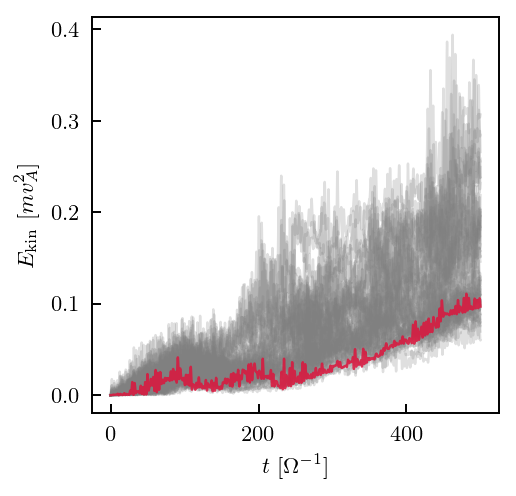

In [11]:
#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
#plt.yscale('log')
#plt.hist(vout[25][:,0], bins=30, normed=1.0, color='darkslateblue', alpha=0.9)

#plt.plot(xout[1:-1,0,0], xout[1:-1,0,1], lw=1., alpha=0.75, c='gray', label='target pdf')
#plt.scatter(xout[1,0,0], xout[1,0,1], lw=0.5, s=20.)
#plt.scatter(xout[-2,0,0], xout[-2,0,1], lw=0.5, s=20.)

#plt.plot(tout[1:-1], vout[1:-1,0:5,0], lw=1., alpha=0.75, c='crimson', label='target pdf')
plt.plot(t[:], Ekt[:,1:50], lw=1., alpha=0.25, c='gray', label='')
plt.plot(t[:], Ekt[:,0], lw=1., alpha=0.85, c='crimson', label='')

plt.xlabel(r'$t \; [\Omega^{-1}]$')
plt.ylabel(r'$E_{\rm kin} \; [mv_A^2]$')
#plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

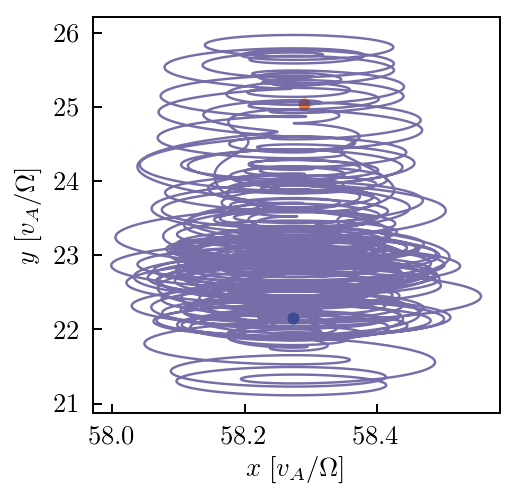

In [12]:
#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
#plt.yscale('log')
#plt.hist(vout[25][:,0], bins=30, normed=1.0, color='darkslateblue', alpha=0.9)

#plt.plot(xout[1:-1,:,0], xout[1:-1,:,1], lw=1., alpha=0.25, c='gray', label='target pdf')

ind = 0
plt.plot(xt[:,ind,0], xt[:,ind,1], lw=1., alpha=0.75, c='darkslateblue')
plt.scatter(xt[0,ind,0], xt[0,ind,1], lw=0.5, s=20.)
plt.scatter(xt[-1,ind,0], xt[-1,ind,1], lw=0.5, s=20.)

plt.xlabel(r'$x \; [v_A/\Omega]$')
plt.ylabel(r'$y \; [v_A/\Omega]$')
#plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

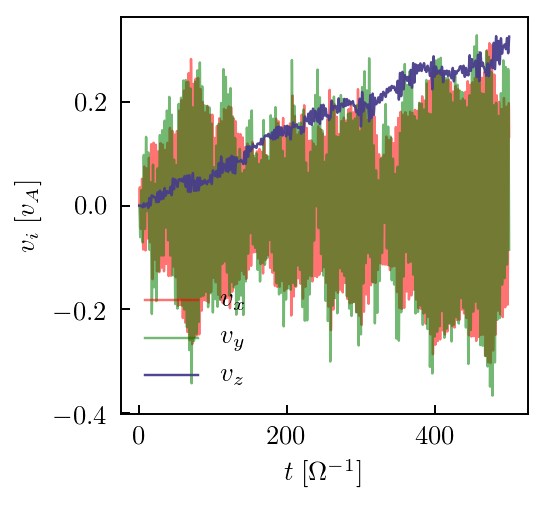

In [13]:
#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))

ind = 1
plt.plot(t, vt[:,ind,0], lw=1., alpha=0.55, c='r', label=r'$v_x$')
plt.plot(t, vt[:,ind,1], lw=1., alpha=0.55, c='g', label=r'$v_y$')
plt.plot(t, vt[:,ind,2], lw=1., alpha=0.95, c='darkslateblue', label=r'$v_z$')

plt.xlabel(r'$t \; [\Omega^{-1}]$')
plt.ylabel(r'$v_i \; [v_A]$')
plt.legend(loc='lower left', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

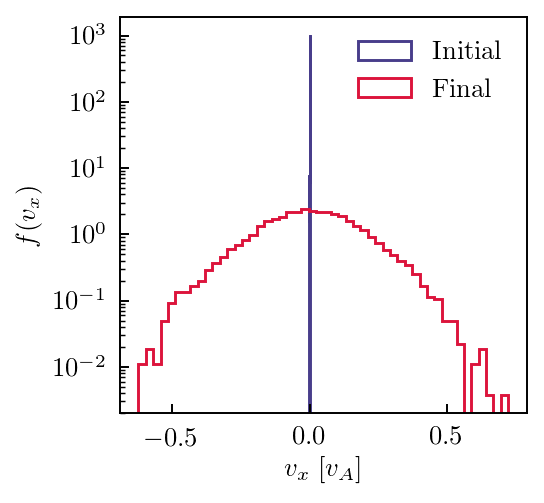

In [23]:
#vtot = np.sqrt(np.sum(vout*vout,1))

#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
plt.yscale('log'); #plt.xscale('log')
plt.hist(vt[0,:,0], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'darkslateblue', linewidth=1.2, label='Initial')

plt.hist(vt[-1,:,0], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'crimson', linewidth=1.2, label='Final')
#plt.plot(lM, dndlnM_SMT/hi1/np.log10(np.exp(1.0)), lw=1., alpha=0.75, c='magenta', label='target pdf')

plt.xlabel(r'$v_x \; [v_A]$')
plt.ylabel(r'$f(v_x)$')
plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

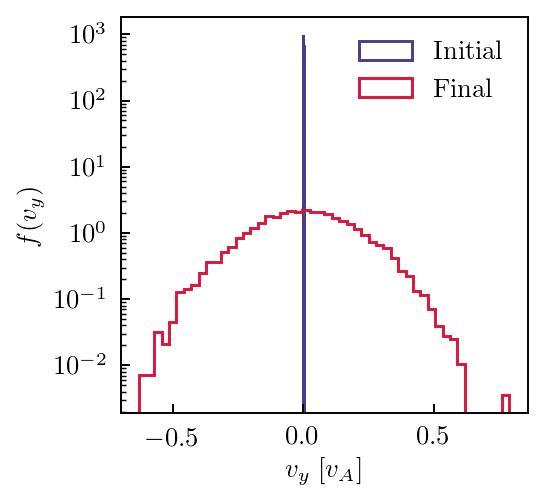

In [24]:
#vtot = np.sqrt(np.sum(vout*vout,1))

#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
plt.yscale('log'); #plt.xscale('log')
plt.hist(vt[0,:,1], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'darkslateblue', linewidth=1.2, label='Initial')

plt.hist(vt[-1,:,1], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'crimson', linewidth=1.2, label='Final')
#plt.plot(lM, dndlnM_SMT/hi1/np.log10(np.exp(1.0)), lw=1., alpha=0.75, c='magenta', label='target pdf')

plt.xlabel(r'$v_y \; [v_A]$')
plt.ylabel(r'$f(v_y)$')
plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

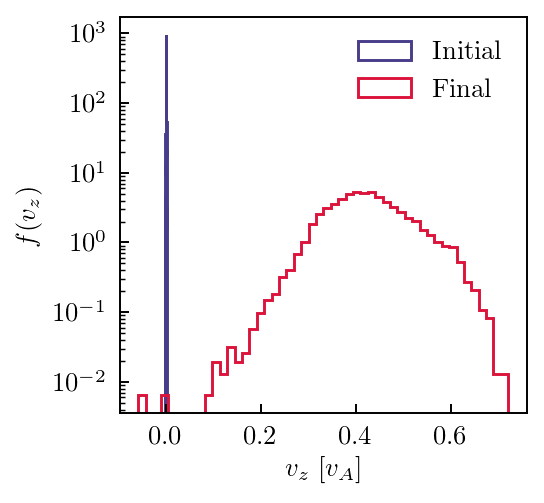

In [26]:
#vtot = np.sqrt(np.sum(vout*vout,1))

#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
plt.yscale('log'); #plt.xscale('log')
plt.hist(vt[0,:,2], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'darkslateblue', linewidth=1.2, label='Initial')

plt.hist(vt[-1,:,2], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'crimson', linewidth=1.2, label='Final')
#plt.plot(lM, dndlnM_SMT/hi1/np.log10(np.exp(1.0)), lw=1., alpha=0.75, c='magenta', label='target pdf')

plt.xlabel(r'$v_z \; [v_A]$')
plt.ylabel(r'$f(v_z)$')
plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

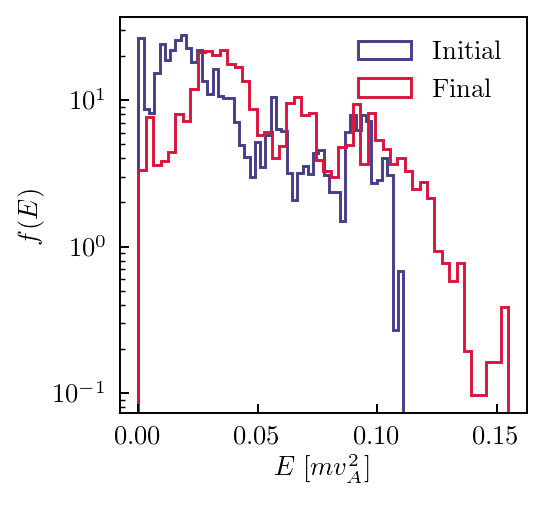

In [41]:
#vtot = np.sqrt(np.sum(vout*vout,1))

#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
plt.yscale('log'); #plt.xscale('log')
plt.hist(Ekt[:,0], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'darkslateblue', linewidth=1.2, label='Initial')

plt.hist(Ekt[:,-1], normed=True, bins=50, histtype='step',\
             stacked=True, fill=False, color = 'crimson', linewidth=1.2, label='Final')
#plt.plot(lM, dndlnM_SMT/hi1/np.log10(np.exp(1.0)), lw=1., alpha=0.75, c='magenta', label='target pdf')

plt.xlabel(r'$E \; [mv_A^2]$')
plt.ylabel(r'$f(E)$')
plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()